# Requirements

In [ ]:
# Add as many imports as you need.

In [6]:
# Add as many imports as you need.
# Write your code here. Add as many boxes as you need.

# Add as many imports as you need.
# Add as many imports as you need.
import pandas as pd

from VNP.packages.data_alalysis import *
from VNP.packages.data_preperation import *
from VNP.packages.missing_values import *
from VNP.packages.visualization import *
from VNP.packages.models import *
from VNP.packages.evaluation import *
from VNP.packages.vnp_ez import *
%load_ext autoreload
%autoreload 2

In [7]:
from keras.api.models import Sequential
from keras.api.layers import Input, LSTM, Dense
import keras

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points represent a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is **exceptional** based on its review.

## The Wine Reviews Dataset

Load the dataset using the `datasets` library.

In [12]:
# Write your code here. Add as many boxes as you need.
from datasets import load_dataset

dataset = load_dataset("csv", data_files="../data/wine-reviews.csv", split="train[:100]")
dataset

Dataset({
    features: ['description', 'points'],
    num_rows: 100
})

In [13]:
df = dataset.to_pandas()

In [14]:
df

,description,points
0,"Translucent in color, silky in the mouth, this...",85
1,"On the palate, this wine is rich and complex, ...",92
2,The producer blends 57% Chardonnay from the Ma...,92
3,"Pure Baga in all its glory, packed with dry an...",93
4,Think of Subsídio as a contribution rather tha...,89
...,...,...
95,"Crisp and fresh, this is a light wine that is ...",88
96,The black-cherry fruit on the nose of this win...,85
97,Corte Lenguin's Amarone is less intense aromat...,87
98,"Opulent and very minerally, this is deeply fla...",92


In [15]:
df["label"] = df["points"].apply(lambda x: 1 if x > 90 else 0 )

In [17]:
df_1 =  df.drop(columns="points")

In [19]:
df_1.to_csv("../data/wine_dataset-result.csv")

In [42]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="../data/wine_dataset-result.csv", split="train[:100]")
dataset

Dataset({
    features: ['Unnamed: 0', 'description', 'label'],
    num_rows: 100
})

In [43]:
df = dataset.to_pandas()
classes = df["label"].unique()
num_classes = len(classes)

In [44]:
num_classes

2

In [45]:
df

,Unnamed: 0,description,label
0,0,"Translucent in color, silky in the mouth, this...",0
1,1,"On the palate, this wine is rich and complex, ...",1
2,2,The producer blends 57% Chardonnay from the Ma...,1
3,3,"Pure Baga in all its glory, packed with dry an...",1
4,4,Think of Subsídio as a contribution rather tha...,0
...,...,...,...
95,95,"Crisp and fresh, this is a light wine that is ...",0
96,96,The black-cherry fruit on the nose of this win...,0
97,97,Corte Lenguin's Amarone is less intense aromat...,0
98,98,"Opulent and very minerally, this is deeply fla...",1


In [46]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = dataset["label"]

In [47]:
labels

[0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0]

In [48]:
dataset = dataset.remove_columns("Unnamed: 0")
dataset = dataset.rename_column("description", "text")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 100
})

In [49]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 80
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 20
    })
})

In [59]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [60]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [61]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [62]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 80
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 20
    })
})

In [63]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=3,
)

In [64]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_classes, ignore_mismatched_sizes=True)

In [65]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [66]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [81]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    num_train_epochs=3
)

TypeError: Trainer.__init__() got an unexpected keyword argument 'num_train_epoch'

In [68]:
import torch

torch.cuda.is_available()

False

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [70]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [71]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.916491,0.487179
2,No log,0.700425,0.548872
3,No log,0.742757,0.494949


TrainOutput(global_step=30, training_loss=0.9033376057942708, metrics={'train_runtime': 52.0328, 'train_samples_per_second': 4.612, 'train_steps_per_second': 0.577, 'total_flos': 5095855242048.0, 'train_loss': 0.9033376057942708, 'epoch': 3.0})

In [72]:
trainer.evaluate()

{'eval_loss': 0.7427568435668945,
 'eval_f1': 0.494949494949495,
 'eval_runtime': 0.5634,
 'eval_samples_per_second': 35.5,
 'eval_steps_per_second': 5.325,
 'epoch': 3.0}

In [73]:
predictions = trainer.predict(tokenized_dataset["test"])

In [74]:
predictions

PredictionOutput(predictions=array([[-0.43529627,  0.40497088],
       [ 0.934933  , -0.9207424 ],
       [-0.30355456,  0.25142625],
       [ 0.6499145 , -0.64903754],
       [-0.2530553 ,  0.23199105],
       [-0.90618527,  0.95209134],
       [ 0.03633247, -0.06215917],
       [-0.33580825,  0.34919024],
       [ 0.70661557, -0.69130886],
       [ 0.83614266, -0.8324322 ],
       [ 0.6005449 , -0.6694019 ],
       [-0.6118674 ,  0.61589634],
       [-0.93214893,  0.9199854 ],
       [ 0.3259286 , -0.29029614],
       [-0.3770496 ,  0.34467942],
       [ 0.81359166, -0.77232933],
       [ 0.592796  , -0.61605424],
       [ 0.32348832, -0.29490668],
       [ 0.8606274 , -0.8684068 ],
       [ 0.7986207 , -0.7299131 ]], dtype=float32), label_ids=array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1]), metrics={'test_loss': 0.7427568435668945, 'test_f1': 0.494949494949495, 'test_runtime': 1.2611, 'test_samples_per_second': 15.859, 'test_steps_per_second': 2.379})

In [75]:
logits, labels = predictions.predictions, predictions.label_ids
preds_args = np.argmax(logits, axis=-1)

In [76]:
preds_args

array([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0])

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
print(classification_report(labels, preds_args))

              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.50      0.40      0.44        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.49        20
weighted avg       0.50      0.50      0.49        20



Text(0.5, 1.0, 'Confusion Matrix')

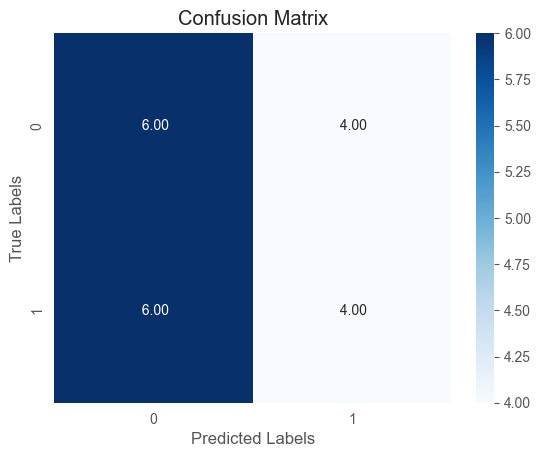

In [79]:
sns.heatmap(confusion_matrix(labels, preds_args), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

## Target Extraction
Extract the target **exceptional** for each wine review. If some wine has at least 90 points it is considered **exceptional**.

In [ ]:
# Write your code here. Add as many boxes as you need.

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [ ]:
# Write your code here. Add as many boxes as you need.

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [ ]:
# Write your code here. Add as many boxes as you need.

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [ ]:
# Write your code here. Add as many boxes as you need.

Define the traning parameters using the `TrainingArguments` class.

In [ ]:
# Write your code here. Add as many boxes as you need.

Define the training using the `Trainer` class.

In [ ]:
# Write your code here. Add as many boxes as you need.

Fine-tune (train) the pre-trained lanugage model.

In [ ]:
# Write your code here. Add as many boxes as you need.

Use the trained model to make predictions for the test set.

In [ ]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify wine reviews as **exceptional** or not. Use TF-IDF vectorization to convert text into numerical features and train a logistic regression. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. Analyze the texts to find the most influential words or phrases associated with the **exceptional** wines. Use the coefficients from the logistic regression trained on TF-IDF features to identify the top positive and negative keywords for **exceptional** wines. Present these keywords in a simple table or visualization (e.g., bar chart).

In [ ]:
# Write your code here. Add as many boxes as you need.